<a href="https://colab.research.google.com/github/Amjadkp/DIGITAL-IMAGE-PROCESSING/blob/main/set3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 1: Restore a Degraded Image using Direct Inverse Filtering**

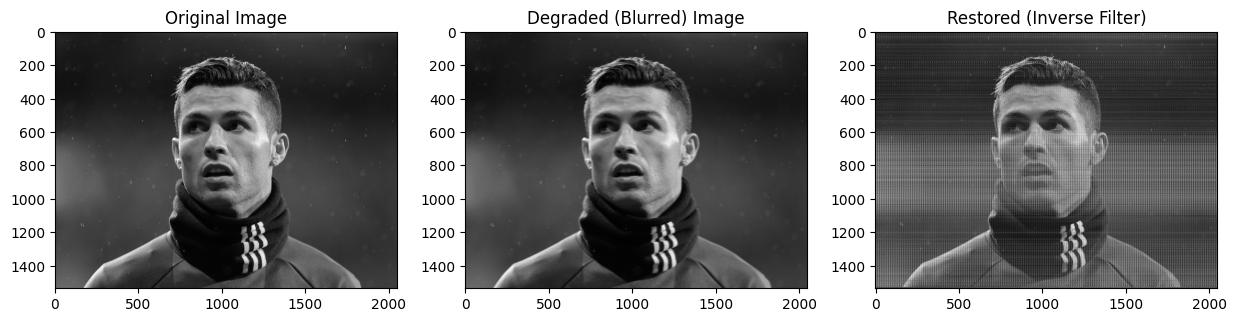

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inverse_filter_restoration(image_path, filter_size=5):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return

    # --- 1. Simulate Degradation (Motion Blur) ---
    H_blur = np.zeros(img.shape, dtype=np.float32)
    # Create a simple uniform motion blur kernel (e.g., 1/filter_size along x-axis)
    kernel = np.zeros((filter_size, filter_size), dtype=np.float32)
    kernel[int((filter_size - 1) / 2), :] = 1 / filter_size

    # Apply the kernel to the image (spatial domain)
    img_degraded = cv2.filter2D(img, -1, kernel)

    # Convert to float and perform FFT for frequency domain processing
    img_degraded_float = np.float32(img_degraded)
    F_degraded = np.fft.fft2(img_degraded_float)

    # --- 2. Inverse Filter Restoration ---

    # Create the filter (PSF) in the frequency domain, H(u,v)
    # Pad the kernel to the size of the image for correct FFT
    h, w = img.shape
    kernel_padded = np.zeros((h, w), dtype=np.float32)

    # Place the kernel at the top-left corner
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    # Compute the FFT of the padded kernel (the transfer function H(u,v))
    H = np.fft.fft2(kernel_padded)

    # Inverse filter: F_restored(u,v) = G(u,v) / H(u,v)
    # Add a small constant to the denominator to avoid division by zero (regularization)
    epsilon = 1e-6
    H_inv = 1 / (H + epsilon)

    F_restored = F_degraded * H_inv

    # Inverse FFT to get the restored image in the spatial domain
    img_restored = np.fft.ifft2(F_restored)
    img_restored = np.real(img_restored)

    # Clip and convert back to 8-bit image format
    img_restored = np.clip(img_restored, 0, 255).astype(np.uint8)

    # --- 3. Display Results ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(img_degraded, cmap='gray'), plt.title('Degraded (Blurred) Image')
    plt.subplot(1, 3, 3), plt.imshow(img_restored, cmap='gray'), plt.title('Restored (Inverse Filter)')
    plt.show()

# Example usage: Replace 'sample_image.jpg' with your file name
inverse_filter_restoration('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg', filter_size=11)

**Problem 2: Wiener Filtering for Image Restoration (Constant Ratio)**

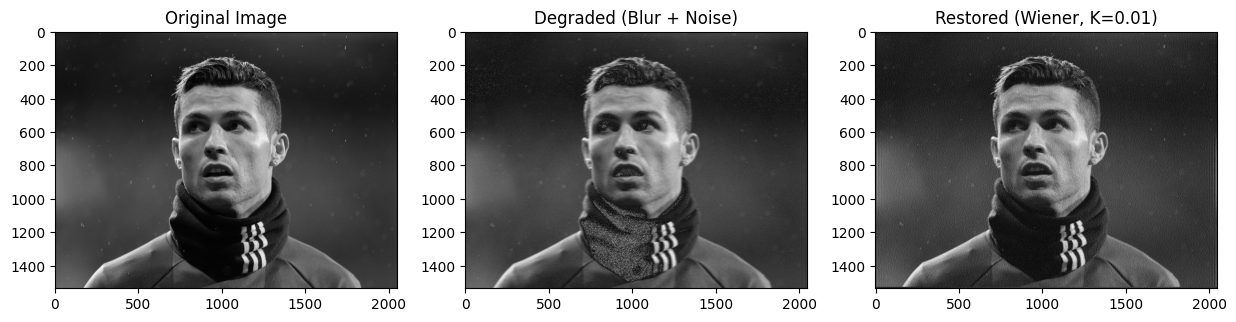

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def wiener_filter_restoration(image_path, filter_size=11, K=0.01):
    # K is the constant ratio of noise power spectrum to signal power spectrum (an estimate)

    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image. Please upload an image file.")
        return

    img_float = np.float32(img)
    rows, cols = img.shape

    # --- 1. Simulate Degradation (Motion Blur + Gaussian Noise) ---

    # Create a motion blur kernel (PSF)
    kernel = np.zeros((filter_size, filter_size), dtype=np.float32)
    kernel[int((filter_size - 1) / 2), :] = 1 / filter_size

    # Apply Blur
    img_degraded = cv2.filter2D(img_float, -1, kernel)

    # Add Gaussian Noise
    noise = np.random.normal(0, 10, img.shape)
    img_degraded += noise

    # --- 2. Wiener Filter Restoration (Frequency Domain) ---

    # Get the Transfer Function H(u,v) by FFT of the padded kernel
    kernel_padded = np.zeros((rows, cols), dtype=np.float32)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    H = np.fft.fft2(kernel_padded)
    H_conj = np.conj(H)
    H_abs_sq = np.abs(H)**2

    # Wiener Filter Formula (Constant K): H_w(u,v) = [H*(u,v) / (|H(u,v)|^2 + K)]
    # This formula is used for the constant ratio part of the problem.
    H_w = H_conj / (H_abs_sq + K)

    # Apply the filter to the degraded image's FFT
    G = np.fft.fft2(img_degraded)
    F_restored = G * H_w

    # Inverse FFT to get the restored image
    img_restored = np.fft.ifft2(F_restored)
    img_restored = np.real(img_restored)

    # Clip and convert back to 8-bit image format
    img_restored_int = np.clip(img_restored, 0, 255).astype(np.uint8)

    # --- 3. Display Results ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(img_degraded.astype(np.uint8), cmap='gray'), plt.title('Degraded (Blur + Noise)')
    plt.subplot(1, 3, 3), plt.imshow(img_restored_int, cmap='gray'), plt.title(f'Restored (Wiener, K={K})')
    plt.show()

# Example usage:
wiener_filter_restoration('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg', filter_size=15, K=0.01)

**Problem 3 & 4: RGB to HSI and Histogram Equalization**

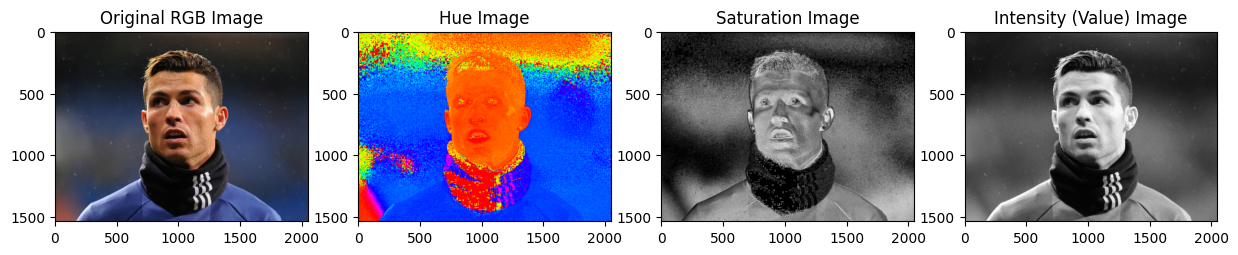

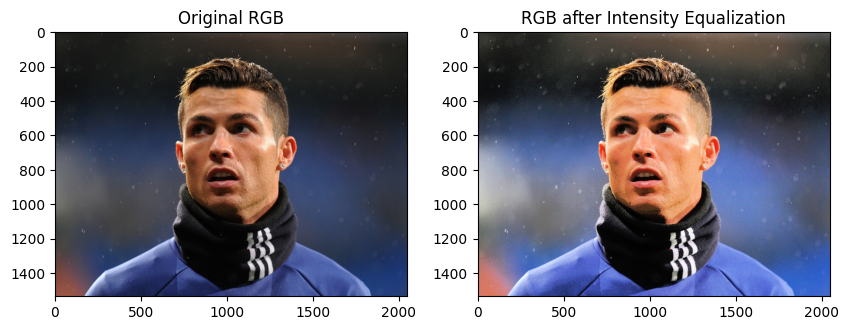

/tmp/ipython-input-755174390.py:53: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(V.flatten(), 256, [0, 256], color='r', label='Original V')
/tmp/ipython-input-755174390.py:54: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(V_equalized.flatten(), 256, [0, 256], color='b', alpha=0.5, label='Equalized V')


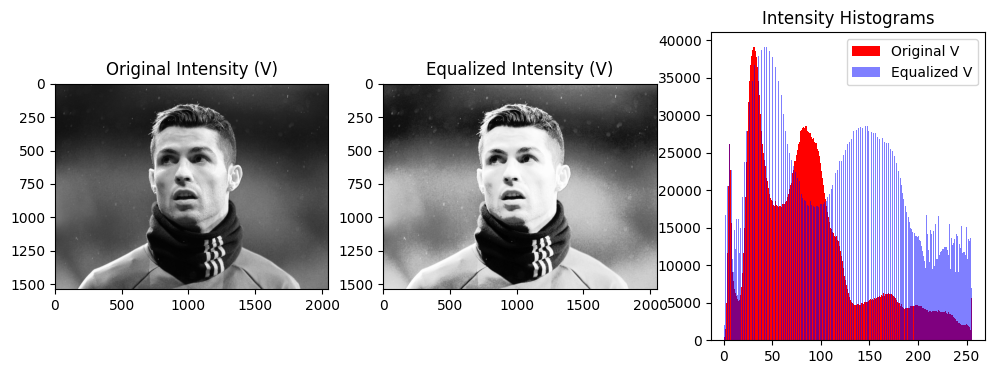

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hsi_conversion_and_equalization(image_path):
    # 1. Load the image
    img_rgb = cv2.imread(image_path)
    if img_rgb is None:
        print("Error: Could not load image.")
        return

    # OpenCV loads images as BGR, convert to RGB for standard display
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

    # --- 3. Convert RGB to HSI (using HSV) ---
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # Split the H, S, and I (V) components
    H, S, V = cv2.split(img_hsv) # V is the Intensity component

    # Display the components
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1), plt.imshow(img_rgb), plt.title('Original RGB Image')
    plt.subplot(1, 4, 2), plt.imshow(H, cmap='hsv'), plt.title('Hue Image')
    plt.subplot(1, 4, 3), plt.imshow(S, cmap='gray'), plt.title('Saturation Image')
    plt.subplot(1, 4, 4), plt.imshow(V, cmap='gray'), plt.title('Intensity (Value) Image')
    plt.show()

    # --- 4. Histogram Equalize the Intensity component ---

    # Histogram equalization on the Intensity component (V)
    V_equalized = cv2.equalizeHist(V)

    # Merge the new Intensity component with the original H and S
    # This creates the new HSI (HSV) image
    new_hsv = cv2.merge([H, S, V_equalized])

    # Convert the new HSI image back to RGB
    img_equalized_rgb = cv2.cvtColor(new_hsv, cv2.COLOR_HSV2RGB)

    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1), plt.imshow(img_rgb), plt.title('Original RGB')
    plt.subplot(1, 2, 2), plt.imshow(img_equalized_rgb), plt.title('RGB after Intensity Equalization')
    plt.show()

    # Optional: Display V_equalized and its histogram
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1), plt.imshow(V, cmap='gray'), plt.title('Original Intensity (V)')
    plt.subplot(1, 3, 2), plt.imshow(V_equalized, cmap='gray'), plt.title('Equalized Intensity (V)')

    plt.subplot(1, 3, 3)
    plt.hist(V.flatten(), 256, [0, 256], color='r', label='Original V')
    plt.hist(V_equalized.flatten(), 256, [0, 256], color='b', alpha=0.5, label='Equalized V')
    plt.title('Intensity Histograms')
    plt.legend()
    plt.show()


# Example usage: Replace 'sample_image.jpg' with your file name
hsi_conversion_and_equalization('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg')

**Problem 5: Detect Line Segments using Hough Transform**

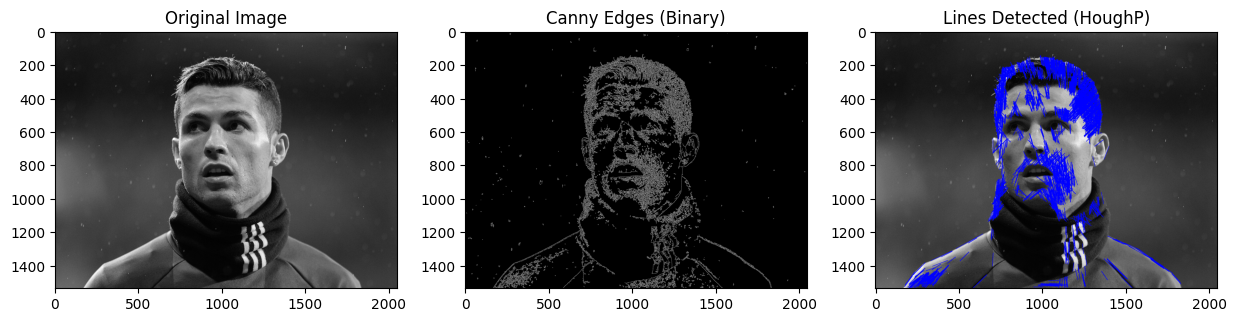

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hough_line_detection(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return

    # 1. Edge Detection (to create a binary edge map)
    edges = cv2.Canny(img, 50, 150, apertureSize=3)

    # 2. Apply Hough Transform
    # The image to draw lines on (color copy of original)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # cv2.HoughLinesP (Probabilistic Hough Line Transform) is typically used for line *segments*
    # Arguments: (image, rho_resolution, theta_resolution, threshold, min_line_length, max_line_gap)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10)

    # 3. Draw the detected line segments
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Draw the line segment in red (0, 0, 255)
            cv2.line(img_rgb, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # 4. Display Results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(edges, cmap='gray'), plt.title('Canny Edges (Binary)')
    plt.subplot(1, 3, 3), plt.imshow(img_rgb), plt.title('Lines Detected (HoughP)')
    plt.show()

# Example usage: Replace 'sample_image.jpg' with your file name
hough_line_detection('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg')

**Problem 6: Segment Blobs based on Thresholding**

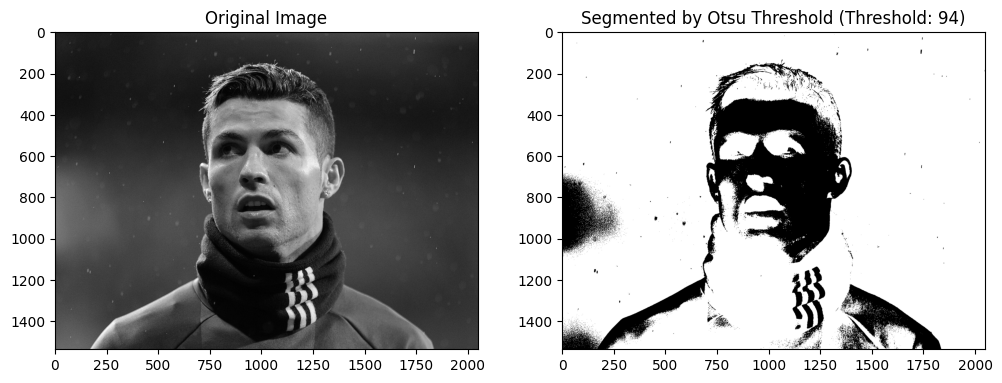

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def threshold_segmentation(image_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image. Please upload an image file.")
        return

    # Use Otsu's method to automatically find the optimal global threshold
    # The output is a binary image where the blobs are segmented.
    # cv2.THRESH_BINARY_INV is often used for dark objects on a light background.
    ret, segmented_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # --- Display Results ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 2, 2), plt.imshow(segmented_img, cmap='gray'), plt.title(f'Segmented by Otsu Threshold (Threshold: {ret:.0f})')
    plt.show()

# Example usage:
threshold_segmentation('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg')

**Problem 7: Segment Blobs based on Region Growing**

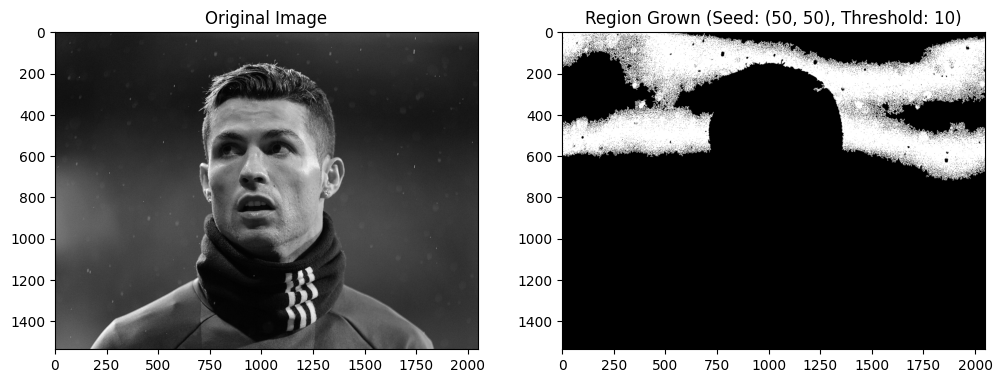

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def region_growing_segmentation(image_path, seed_point, intensity_threshold=5):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image. Please upload an image file.")
        return

    rows, cols = img.shape
    segmented = np.zeros_like(img, dtype=np.uint8)

    # Initialize the region
    seed_value = img[seed_point]

    # Queue for breadth-first search (BFS) of neighbors
    queue = deque([seed_point])

    # Mark the seed point as processed
    segmented[seed_point] = 255

    # Directions for 4-connectivity neighbors
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # --- Region Growing Loop ---
    while queue:
        r, c = queue.popleft()

        for dr, dc in neighbors:
            nr, nc = r + dr, c + dc

            # Check boundaries and if already segmented
            if 0 <= nr < rows and 0 <= nc < cols and segmented[nr, nc] == 0:

                # Similarity criterion: absolute difference from the seed value
                if abs(int(img[nr, nc]) - int(seed_value)) <= intensity_threshold:
                    segmented[nr, nc] = 255
                    queue.append((nr, nc))

    # --- Display Results ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 2, 2), plt.imshow(segmented, cmap='gray'), plt.title(f'Region Grown (Seed: {seed_point}, Threshold: {intensity_threshold})')
    plt.show()

# Example usage:
# Note: You must manually select a seed point (row, col) that is inside a blob.
region_growing_segmentation('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg', seed_point=(50, 50), intensity_threshold=10)

**Problem 8: Split and Merge Procedure for Segmentation (Quad-Tree based)**

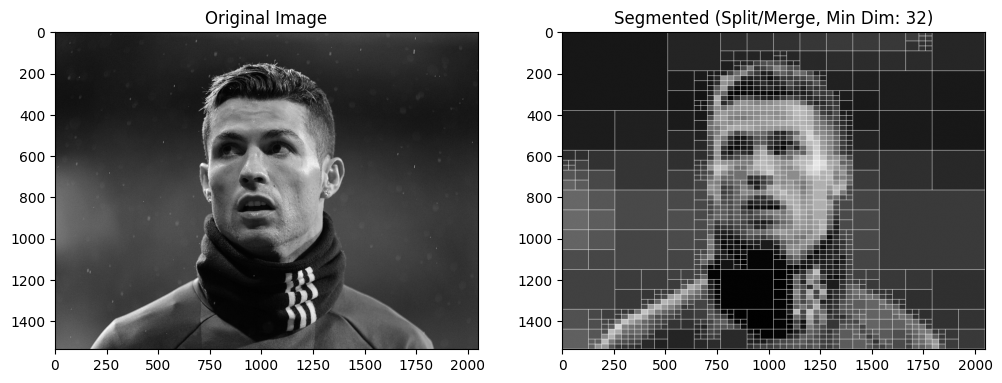

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import variance

# Global list to store the final uniform regions
FINAL_SEGMENTS = []

def split_quad(region, min_dim):
    """Recursively splits a region if it's non-uniform and larger than min_dim."""
    global FINAL_SEGMENTS
    r, c, h, w = region
    sub_image = img_global[r:r+h, c:c+w]

    # Uniformity Test: Check if variance is above a threshold (e.g., 100)
    is_uniform = variance(sub_image) < 100

    # Stop condition: Region is uniform OR minimum dimension is reached
    if is_uniform or (h <= min_dim and w <= min_dim):
        FINAL_SEGMENTS.append(region)
        return

    # Split: Divide the region into four quadrants
    nh, nw = h // 2, w // 2

    # Top-Left
    split_quad((r, c, nh, nw), min_dim)
    # Top-Right
    split_quad((r, c + nw, nh, w - nw), min_dim)
    # Bottom-Left
    split_quad((r + nh, c, h - nh, nw), min_dim)
    # Bottom-Right
    split_quad((r + nh, c + nw, h - nh, w - nw), min_dim)

def merge_regions():
    """Simple merge step: Draw boundaries to visualize the split."""
    # The full implementation of MERGE is complex (requires checking adjacency and similarity).
    # This function is simplified to just visualize the SPLIT result.

    global FINAL_SEGMENTS, img_global
    img_segmented = np.zeros_like(img_global, dtype=np.uint8)

    # For visualization, color each final segment with its mean intensity
    for r, c, h, w in FINAL_SEGMENTS:
        mean_val = np.mean(img_global[r:r+h, c:c+w])
        img_segmented[r:r+h, c:c+w] = mean_val

        # Draw boundaries for visualization
        cv2.rectangle(img_segmented, (c, r), (c + w - 1, r + h - 1), 255, 1)

    return img_segmented

def split_and_merge_segmentation(image_path, min_dim=32):
    global img_global, FINAL_SEGMENTS
    FINAL_SEGMENTS = [] # Reset global list for new run

    # Load the image in grayscale
    img_global = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_global is None:
        print("Error: Could not load image. Please upload an image file.")
        return

    rows, cols = img_global.shape

    # 1. Split Procedure (Recursive Quad-Tree)
    # Initial region is the entire image (row, col, height, width)
    split_quad((0, 0, rows, cols), min_dim)

    # 2. Merge Procedure (Simplified Visualization)
    img_segmented = merge_regions()

    # --- Display Results ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1), plt.imshow(img_global, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 2, 2), plt.imshow(img_segmented, cmap='gray'), plt.title(f'Segmented (Split/Merge, Min Dim: {min_dim})')
    plt.show()

# Example usage:
split_and_merge_segmentation('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg', min_dim=32)

**Problem 9: Segment Blobs using Watershed Transform**

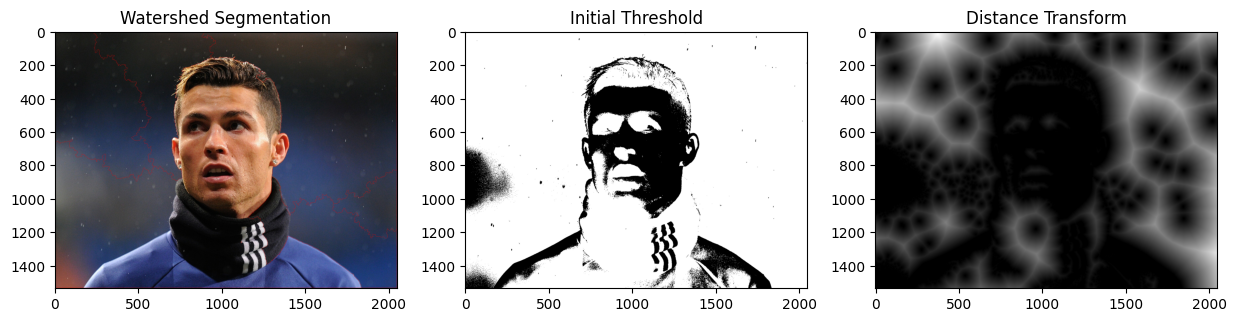

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def watershed_segmentation(image_path):
    # 1. Load and Preprocess Image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not load image.")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Apply threshold to get a binary image (for small, non-overlapping blobs, thresholding works well)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 2. Noise Removal (Optional but good practice)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # 3. Determine Background and Foreground
    # Sure background area (dilate the opening)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Sure foreground area (distance transform and threshold)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # Thresholding the distance map gives separated blobs (sure foreground)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Unknown region is the boundary between sure_fg and sure_bg
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # 4. Marker Generation
    # Label the sure foreground regions (blobs)
    _, markers = cv2.connectedComponents(sure_fg)

    # Add 1 to all labels so that sure background is 1
    markers = markers + 1

    # Mark the unknown region with 0
    markers[unknown == 255] = 0

    # 5. Apply Watershed Algorithm
    # Convert markers to int32 as required by cv2.watershed
    markers = cv2.watershed(img_bgr, markers)

    # 6. Visualize Result
    # Mark the boundaries (where markers == -1) in red on the original image
    img_bgr[markers == -1] = [0, 0, 255] # Red boundary lines

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)), plt.title('Watershed Segmentation')
    plt.subplot(1, 3, 2), plt.imshow(thresh, cmap='gray'), plt.title('Initial Threshold')
    plt.subplot(1, 3, 3), plt.imshow(dist_transform, cmap='gray'), plt.title('Distance Transform')
    plt.show()

# Example usage: Replace 'sample_image.jpg' with your file name
watershed_segmentation('/content/100334-2048x1536-desktop-hd-cristiano-ronaldo-wallpaper-photo.jpg')